<a href="https://colab.research.google.com/github/kennardmah/google-cloud-coursera-courses/blob/master/AP5_SupportVectorMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# import all libraries used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import sklearn.tree as tree
import graphviz
import pylab

In [21]:
# read original dataset and create dataframe object
hdf = pd.read_csv('kc_house_data.csv')
hdf = pd.DataFrame(hdf)

In [22]:
# remove variables we do not plan to use
hdf = hdf.drop(columns=['id','date','zipcode'])

meanPrice = hdf['price'].mean()
print(meanPrice)

# separate continous and categorical variables
continuous_hdf = hdf[['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15']]
categorical_hdf = hdf.drop(columns=['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors','sqft_above','sqft_basement','lat','long','sqft_living15','sqft_lot15'])

# restitch dataset but now with all continuous variables together
hdf = pd.concat([continuous_hdf, categorical_hdf], axis=1)

540088.1417665294


In [23]:
# make variables view, grade, condition binarised
hdf['view_b'] = hdf['view'] > 2
hdf['view_b'] = hdf['view_b'].astype(int)
hdf['condition_b'] = hdf['condition'] > 3
hdf['condition_b'] = hdf['condition_b'].astype(int)
hdf['grade_b'] = hdf['grade'] > 7
hdf['grade_b'] = hdf['grade_b'].astype(int)

# function to combine year built and year renovated into one binarised variable to see if house has been updated or created after 2000
def label_new(row):
    if row['yr_renovated'] > 2000 :
        return '1'
    elif row['yr_built'] > 2000 :
        return '1'
    else:
        return '0'

hdf['is_new_or_renovated'] = hdf.apply(lambda row: label_new(row), axis=1)
hdf['is_new_or_renovated'] = hdf['is_new_or_renovated'].astype(int)

# remove original unbinarised data columns
hdf = hdf.drop(columns=['view','grade','condition','yr_built','yr_renovated'])

# create a copy of the dataframe with price column removed
price_pd = pd.DataFrame(hdf.copy().pop('price'))

# BINARISE PRICE TO DETERMINE WHETHER PROPERTY IS UPPER VALUE OR LOWER VALUE
price_pd['price_range'] = hdf['price'] > 540088.1418

In [25]:
# dataframe copy for preprocessing
hdf_prepro = hdf.copy()
# ADD BINARY PRICE VARIABLE
hdf_prepro['Price Range'] = price_pd['price_range']
# remove columns no longer needed
hdf_prepro = hdf_prepro.drop(['sqft_above'], axis=1)
hdf_prepro = hdf_prepro.drop(['price'], axis=1)

In [26]:
hdf_prepro['Price Range'].value_counts()

False    13694
True      7919
Name: Price Range, dtype: int64

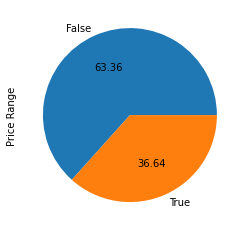

In [27]:
hdf_prepro['Price Range'].value_counts().plot.pie(autopct = '%.2f')

In [28]:
# create csv of processed data
hdf_prepro.to_csv("KC_House_Processed_Data.csv")

In [29]:
# creates training, validation, and test sets with 80/10/10
train, other = train_test_split(hdf_prepro, test_size=0.2, random_state=0)
validation, test = train_test_split(other, test_size=0.5, random_state=0)

# X sets include all attributes except price range, y sets are just price range
X_train = train.drop(['Price Range'], axis = 1)
y_train = train['Price Range']
X_val = validation.drop(['Price Range'], axis = 1)
y_val = validation['Price Range']
X_test = test.drop(['Price Range'], axis = 1)
y_test = test['Price Range']
X_train.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,3,1.0,1570,5510,1.0,500,47.6942,-122.319,1770,6380,0,0,1,0,0
16909,3,2.5,1780,11000,1.0,570,47.5574,-122.149,2310,9700,0,0,1,1,0
16123,3,1.5,1090,9862,1.0,0,47.6256,-122.036,1710,9862,0,0,0,1,0
12181,4,2.5,2210,7079,2.0,0,47.4206,-122.183,1970,7000,0,0,0,1,0
12617,3,2.5,1800,4763,2.0,560,47.6460,-122.362,1790,4763,0,0,0,0,0


In [30]:
# standardising (normalising) the data so that the mean=0 and std=1, helps to balance data along with the previous binarisation of some features
means = X_train.mean(axis=0)
stds = X_train.std(axis=0) 

X_train_standardised = (X_train - means) / stds
X_val_standardised = (X_val - means) / stds
X_test_standardised = (X_test - means) / stds

X_train_standardised.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_basement,lat,long,sqft_living15,sqft_lot15,waterfront,view_b,condition_b,grade_b,is_new_or_renovated
5268,-0.390023,-1.448095,-0.553934,-0.230230,-0.917914,0.466341,0.964830,-0.744673,-0.316901,-0.232451,-0.090673,-0.200307,1.395306,-0.961610,-0.549848
16909,-0.390023,0.494282,-0.326475,-0.100351,-0.917914,0.624130,-0.022009,0.463181,0.469978,-0.112885,-0.090673,-0.200307,1.395306,1.039863,-0.549848
16123,-0.390023,-0.800636,-1.073840,-0.127273,-0.917914,-0.660724,0.469968,1.266049,-0.404332,-0.107050,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12181,0.670275,0.494282,0.139273,-0.193112,0.925056,-0.660724,-1.008849,0.221611,-0.025464,-0.210123,-0.090673,-0.200307,-0.716647,1.039863,-0.549848
12617,-0.390023,0.494282,-0.304813,-0.247902,0.925056,0.601588,0.617128,-1.050189,-0.287757,-0.290686,-0.090673,-0.200307,-0.716647,-0.961610,-0.549848


In [31]:
from sklearn.svm import SVC

# BINARISE PRICE TO DETERMINE WHETHER PROPERTY IS UPPER VALUE OR LOWER VALUE

price_pd['price_range'] = hdf['price'] > 540088.1418

# DROPPING COLUMNS THAT ARE NOT BEING USED

X_train_standardised = X_train_standardised.drop(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_basement','lat','long','sqft_living15', 'sqft_lot15'], axis = 1)
X_val_standardised = X_val_standardised.drop(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_basement','lat','long','sqft_living15', 'sqft_lot15'], axis = 1)
X_test_standardised = X_test_standardised.drop(['bedrooms', 'bathrooms', 'sqft_lot', 'floors', 'sqft_basement','lat','long','sqft_living15', 'sqft_lot15'], axis = 1)

In [ ]:
# CHECKPOINT

print(X_train_standardised)
print(y_train)

In [15]:
# DEFINING VALIDATION, TRAINING, AND TESTING FUNCTIONS

def acc_val(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return accuracy_score(y_val, model.predict(X_val_standardised))
def prec_val(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return precision_score(y_val, model.predict(X_val_standardised))
def rec_val(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return recall_score(y_val, model.predict(X_val_standardised))
def acc_train(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return accuracy_score(y_train, model.predict(X_train_standardised))
def prec_train(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return precision_score(y_train, model.predict(X_train_standardised))
def rec_train(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return recall_score(y_train, model.predict(X_train_standardised))
def acc_test(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return accuracy_score(y_test, model.predict(X_test_standardised))
def prec_test(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return precision_score(y_test, model.predict(X_test_standardised))
def rec_test(c,k,g):
  model = SVC(C=c, kernel=k, gamma=g)
  model = model.fit(X_train_standardised, y_train)
  return recall_score(y_test, model.predict(X_test_standardised))

In [ ]:
# SET VARIABLES FOR TEST

kernel_type = ['linear', 'poly', 'rbf', 'sigmoid']
acc_value = []
pre_value = []
rec_value = []
acc_testing = []
pre_testing = []
rec_testing = []

# RUN TEST WITH VARYING KERNEL TYPES

for i in range(len(kernel_type)):
  K = kernel_type[i]
  print('testing with kernel as {}'.format(K))
  SVM3 = SVC(C = 2.5, kernel = K, gamma = 'scale')
  SVM3 = SVM3.fit(X_train_standardised, y_train)
  ypred_val = SVM3.predict(X_val_standardised)
  ypred_test = SVM3.predict(X_test_standardised)
  acc_value.append(accuracy_score(y_val, ypred_val)) 
  pre_value.append(precision_score(y_val, ypred_val))
  rec_value.append(recall_score(y_val, ypred_val))
  acc_testing.append(accuracy_score(y_test, ypred_test)) 
  pre_testing.append(precision_score(y_test, ypred_test))
  rec_testing.append(recall_score(y_test, ypred_test))

# DISPLAY ACCURACY PLOT

plt.plot(kernel_type, acc_value, label='Validation') 
plt.plot(kernel_type, acc_testing, label='Training') 
plt.legend()
plt.title('Accuracy Score vs Kernel Type')
plt.xlabel('Kernel') 
plt.ylabel('Accuracy') 
plt.savefig('Accuracy Score vs Kernel Type')
plt.show()

# DISPLAY PRECISION PLOT

plt.plot(kernel_type, pre_value, label='Validation') 
plt.plot(kernel_type, pre_testing, label='Training') 
plt.legend()
plt.title('Precision Score vs Kernel Type')
plt.xlabel('Kernel') 
plt.ylabel('Precision') 
plt.savefig('Precision Score vs Kernel Type')
plt.show()

# DISPLAY RECALL PLOT

plt.plot(kernel_type, rec_value, label='Validation') 
plt.plot(kernel_type, rec_testing, label='Training') 
plt.legend()
plt.title('Recall Score vs Kernel Type')
plt.xlabel('Kernel') 
plt.ylabel('Recall') 
plt.savefig('Recall Score vs Kernel Type')
plt.show()

In [ ]:
dfacc = pd.DataFrame()
for n in np.linspace(250, 3500, 25):
  dfacc["{}".format(n/1000)] = [acc_val(n/1000,'linear','scale'), acc_test(n/1000,'linear','scale')]
dfacc = dfacc.T   # tranpose 
dfacc.plot()      # plot graph
plt.title('Accuracy Scores vs C-Values')  # plot graph
plt.xlabel('C-Values')
plt.ylabel('Accuracy')
plt.show()
 
dfprec = pd.DataFrame()
for n in np.linspace(250, 3500, 25):
  dfprec["{}".format(n/1000)] = [prec_val(n/1000,'linear','scale'), prec_test(n/1000,'linear','scale')]  
dfprec = dfprec.T
dfprec.plot()
plt.title('Precision Scores vs C-Values')
plt.xlabel('C-Values')
plt.ylabel('Precision')
plt.show()
  
dfrec = pd.DataFrame()
for n in np.linspace(250, 3000, 25):
  dfrec["{}".format(n/1000)] = [rec_val(n/1000,'linear','scale'), rec_test(n/1000,'linear','scale')]  
dfrec = dfrec.T
dfrec.plot()
plt.title('Recall Scores vs C-Values')
plt.xlabel('C-Values')
plt.ylabel('Recall')
plt.show()


In [ ]:
# RUN TEST WITH VARYING C-VALUES

acc1 = pd.DataFrame()
for n in np.linspace(1000, 3500, 25):
  acc1["{}".format(n/1000)] = [acc_val(n/1000,'rbf','scale'), acc_test(n/1000,'rbf','scale')] 
acc1 = acc1.T
acc1.plot()
plt.title('Accuracy Scores vs C-values')
plt.show()
 
prec1 = pd.DataFrame()
for n in np.linspace(1000, 3500, 25):
  prec1["{}".format(n/1000)] = [prec_val(n/1000,'rbf','scale'), prec_test(n/1000,'rbf','scale')]
prec1 = prec1.T
# prec1.plot(label = ['Validation', 'Training'])
prec1.plot()
plt.title('Precision Scores vs C-values')
plt.show()
 
rec1 = pd.DataFrame()
for n in np.linspace(1000, 3500, 25):
  rec1["{}".format(n/1000)] = [rec_val(n/1000,'rbf','scale'), rec_test(n/1000,'rbf','scale')]
rec1 = rec1.T
rec1.plot()
plt.title('Recall Scores vs C-values')
plt.show()

In [ ]:
model = SVC(C=2.7, kernel='linear', gamma='scale')
model = model.fit(X_train_standardised, y_train)
print('Accuracy_Val: {}'.format(accuracy_score(y_val, model.predict(X_val_standardised))))
print('Precision Val: {}'.format(precision_score(y_val, model.predict(X_val_standardised))))
print('Recall Val: {}'.format(recall_score(y_val, model.predict(X_val_standardised))))
print('Accuracy Train: {}'.format(accuracy_score(y_train, model.predict(X_train_standardised))))
print('Precision Train: {}'.format(precision_score(y_train, model.predict(X_train_standardised))))
print('Recall Train: {}'.format(recall_score(y_train, model.predict(X_train_standardised))))
print('Accuracy Test: {}'.format(accuracy_score(y_test, model.predict(X_test_standardised))))
print('Precision Test: {}'.format(precision_score(y_test, model.predict(X_test_standardised))))
print('Recall Test: {}'.format(recall_score(y_test, model.predict(X_test_standardised))))